# Lab 9: Hamiltonian Monte Carlo, Posterior Predictive Checks, and Empirical Bayes with PyMC

### Lab Date: Wednesday, Apr 16

### Lab Due: Wednesday, Apr 30

## Instructions

Work with your lab group to complete the following notebook. Your work will be reviewed by your peers in two weeks (Wednesday, April 30)

In this lab, you will:
1. **Sampling from an intractable posterior using Hamiltonian Monte Carlo (HMC):**  
   Use PyMC to sample from a Bayesian logistic regression model where the posterior is analytically intractable.

2. **Posterior Predictive Checks (PPC):**  
   Use the posterior samples to perform model checking by overlaying a set of inverse-logit curves (drawn from the posterior) on the data.

3. **Empirical Bayes for Hyperparameter Optimization:**  
   Optimize the scale parameter of the prior for $\alpha$ by comparing candidate models using the WAIC metric.

If you are new to working in python, or in a Jupyter notebook, please ask your lab members for help. If you notice a lab member struggling, and have experience, please offer your help.

Please see this [Ed post](https://edstem.org/us/courses/74615/discussion/6463387) for corrections, questions, and discussion. If you would rather work with your own copy of the files, I have uploaded a zip folder there with the lab materials. 

Corrections to the lab will be pushed directly to this notebook. We will only push corrections to the text, which is set to read only to prevent merge conflicts. In the event of a merge conflict, save your notebook under a different name, and click the link that launches the lab from the schedule on the [stat238 homepage](https://stat238.berkeley.edu/spring-2025/) again. Then, check for discrepancies. If you can't find them, or resolve the conflict, contact us.

## Problem Setup: Bayesian Logistic Regression

We consider a binomial logistic regression model. For groups $j = 1, \dots, J$, we observe:

- $y_j \sim \text{Binomial}(n_j, \theta_j)$
- $\theta_j = \text{logit}^{-1}(\alpha + \beta x_j)$

Here:
- $x_j$ is a known covariate for group $j$
- $\alpha, \beta$ are regression coefficients
- $\text{logit}^{-1}(z) = \frac{1}{1 + e^{-z}}$ is the inverse logit function

### Prior Distributions
We place weakly informative priors:
- $\alpha \sim t_4(0, 2^2)$  (Student-t with 4 degrees of freedom, mean 0, scale 2)
- $\beta \sim t_4(0, 1)$

These priors allow for heavier tails than the normal distribution, making them robust.

## 1. Import Required Packages and Define Helper Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import scipy.stats as st
from scipy.special import expit  # logistic (inverse-logit) function

# Set a random seed for reproducibility
np.random.seed(123)

## 2. Simulate the Dataset

In this section, you will simulate a dataset using the model:

$y_j \sim \operatorname{Binomial}(n_j, \operatorname{logit}^{-1}(\alpha + \beta\, x_j))$

where $J = 10$, the covariates $x_j$ are drawn from $\text{Uniform}(-1, 1)$, and the sample sizes $n_j$ are drawn from a Poisson with $\lambda = 5$ (reject any zeros). Use $\alpha_{\text{true}} = 0.5$ and $\beta_{\text{true}} = -1.0$ for simulation.

In [2]:
# Set simulation parameters
J = 10
alpha_true = 0.5
beta_true = -1.0

# Draw x_j from Uniform(-1, 1)
x = np.random.uniform(-1, 1, size=J)

# Draw n_j from a truncated Poisson (reject zeros)
n = np.empty(J, dtype=int)
for j in range(J):
    nj = 0
    while nj < 1:
        nj = np.random.poisson(lam=5)
    n[j] = nj

# Compute the probabilities theta_j = logistic(alpha_true + beta_true * x_j)
theta = expit(alpha_true + beta_true * x)

# Draw y_j ~ Binomial(n_j, theta_j)
y = np.array([np.random.binomial(n_j, theta_j) for n_j, theta_j in zip(n, theta)])

print("x:", np.round(x, 2))
print("n:", n)
print("y:", y)

x: [ 0.39 -0.43 -0.55  0.1   0.44 -0.15  0.96  0.37 -0.04 -0.22]
n: [3 4 8 4 8 7 5 9 4 3]
y: [1 3 7 3 3 5 2 5 3 1]


## 3. Build and Sample the Model in PyMC

PyMC is a powerful, open-source library for probabilistic programming in Python that simplifies the process of building and fitting Bayesian models. It provides an intuitive interface for defining complex statistical models and performing inference using state-of-the-art sampling algorithms such as NUTS. If you're new to PyMC or Bayesian modeling, check out the <a href="https://docs.pymc.io/" style="color: blue;">official PyMC documentation</a> for tutorials, examples, and comprehensive guidance.

In this section, you will:

- Define the Bayesian model using PyMC.
- Use Student‑t priors with 4 degrees of freedom for $\alpha$ (scale = 2) and $\beta$ (scale = 1).
- Define the likelihood: $y_j \sim \operatorname{Binomial}(n_j, \theta_j)$ with $\theta_j = \operatorname{logit}^{-1}(\alpha + \beta\, x_j)$.
- Sample from the posterior using the No-U-Turn Sampler (NUTS), a type of HMC.

Inspect the summary to check if the 50% intervals (the 25th to 75th percentiles) for $\alpha$ and $\beta$ cover the true values.

In [3]:
with pm.Model() as model:
    # Priors for alpha and beta using Student-t distributions
    alpha = pm.StudentT("alpha", nu=4, mu=0, sigma=2)
    beta = pm.StudentT("beta", nu=4, mu=0, sigma=1)
    
    # Logistic regression: theta = logit^{-1}(alpha + beta * x)
    theta = pm.Deterministic("theta", pm.math.sigmoid(alpha + beta * x))
    
    # Likelihood: y_j ~ Binomial(n_j, theta_j)
    y_obs = pm.Binomial("y_obs", n=n, p=theta, observed=y)
    
    # Sample using NUTS (HMC)
    trace = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# Display the posterior summary for alpha and beta
print(az.summary(trace, var_names=["alpha", "beta"]))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.531  0.294  -0.014    1.077      0.004    0.003    5450.0    4817.0   
beta  -1.099  0.613  -2.233    0.063      0.008    0.008    5852.0    4310.0   

       r_hat  
alpha    1.0  
beta     1.0  


## 4. Posterior Predictive Checks (PPC) and Plotting the Fit

Now, generate posterior predictive samples and perform model checking. In this section you will:

- Generate posterior predictive samples for the observed data.
- Create a plot displaying the observed proportions $y_j/n_j$ against $x_j$.
- Overlay many gray curves computed using the inverse-logit function from randomly selected posterior draws. This shows the uncertainty in the model fit.

Check if the 50% posterior intervals for $\alpha$ and $\beta$ (25th to 75th percentiles) contain the true values.

Sampling: [y_obs]


Output()

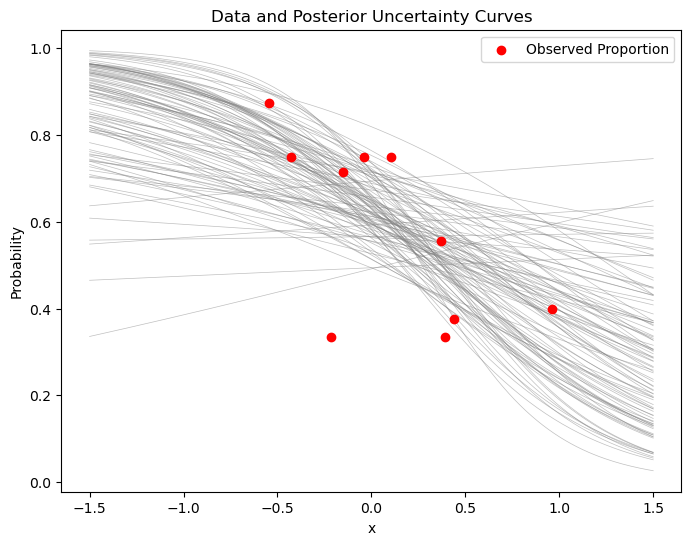

50% posterior interval for alpha: [0.33178099 0.72613157]
True alpha: 0.5
50% posterior interval for beta: [-1.48865308 -0.6854096 ]
True beta: -1.0


In [4]:
# Generate posterior predictive samples
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"])

# Plot the data and fitted uncertainty curves
plt.figure(figsize=(8, 6))

# Plot observed proportions: x vs. y/n
plt.scatter(x, y/n, color='red', zorder=5, label="Observed Proportion")

# Extract posterior samples (combine chains and draws)
posterior_samples = trace.posterior.stack(draws=("chain", "draw"))
n_curves = 100  # number of curves to plot
idx = np.random.choice(posterior_samples.draws.size, n_curves, replace=False)

# Define a grid for x values for plotting the curves
x_plot = np.linspace(-1.5, 1.5, 200)
for i in idx:
    a_sample = posterior_samples["alpha"].values[i]
    b_sample = posterior_samples["beta"].values[i]
    curve = expit(a_sample + b_sample * x_plot)
    plt.plot(x_plot, curve, color="gray", lw=0.5, alpha=0.5)

plt.xlabel("x")
plt.ylabel("Probability")
plt.title("Data and Posterior Uncertainty Curves")
plt.legend()
plt.show()

# Check 50% posterior intervals for alpha and beta (25th to 75th percentiles)
alpha_samples = posterior_samples["alpha"].values
beta_samples = posterior_samples["beta"].values

alpha_interval = np.percentile(alpha_samples, [25, 75])
beta_interval = np.percentile(beta_samples, [25, 75])

print("50% posterior interval for alpha:", alpha_interval)
print("True alpha:", alpha_true)
print("50% posterior interval for beta:", beta_interval)
print("True beta:", beta_true)


## 5. Empirical Bayes: Optimizing Over Prior Parameters

In this section, you will perform a simple empirical Bayes analysis by searching over candidate values for the prior scale of $\alpha$. The idea is to:

- Refit the model using different candidate scales for the prior of $\alpha$.
- Calculate the WAIC for each fitted model.
- Select the candidate scale that minimizes WAIC, which suggests the best fit based on the data.

A grid search is used here for simplicity.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 22 seconds.


Scale candidate 1.00: WAIC = 26.70


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.
Initializing NUTS using jitter+adapt_diag...


Scale candidate 1.10: WAIC = 26.71


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 1.20: WAIC = 26.70


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.


Scale candidate 1.30: WAIC = 26.69


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.


Scale candidate 1.40: WAIC = 26.68


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 1.50: WAIC = 26.74


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 1.60: WAIC = 26.70


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 1.70: WAIC = 26.78


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 1.80: WAIC = 26.75


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.


Scale candidate 1.90: WAIC = 26.70


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 2.00: WAIC = 26.78


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 2.10: WAIC = 26.72


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 2.20: WAIC = 26.73


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.


Scale candidate 2.30: WAIC = 26.75


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 2.40: WAIC = 26.72


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.
Initializing NUTS using jitter+adapt_diag...


Scale candidate 2.50: WAIC = 26.76


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.
Initializing NUTS using jitter+adapt_diag...


Scale candidate 2.60: WAIC = 26.76


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 2.70: WAIC = 26.69


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.


Scale candidate 2.80: WAIC = 26.79


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 2.90: WAIC = 26.74


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]
Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 20 seconds.


Scale candidate 3.00: WAIC = 26.80

Optimal prior scale for alpha (empirical Bayes): 1.40


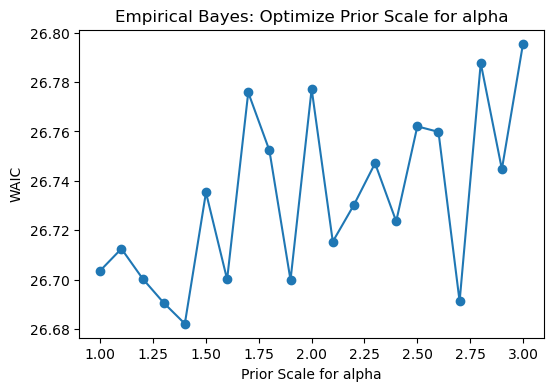

In [6]:
# Define a range of candidate scales for alpha's prior
candidate_scales = np.linspace(1, 3, 21)
waic_values = []

for scale in candidate_scales:
    with pm.Model() as eb_model:
        # Use candidate scale for alpha; beta's prior remains unchanged
        alpha_eb = pm.StudentT("alpha", nu=4, mu=0, sigma=scale)
        beta_eb = pm.StudentT("beta", nu=4, mu=0, sigma=1)
        theta_eb = pm.Deterministic("theta", pm.math.sigmoid(alpha_eb + beta_eb * x))
        y_obs_eb = pm.Binomial("y_obs", n=n, p=theta_eb, observed=y)
        
        # Sample from the model with fewer iterations for speed
        eb_trace = pm.sample(10000, target_accept=0.95, progressbar=False, cores=4, idata_kwargs={"log_likelihood": True})
    
    # Compute WAIC for the model
    waic_val = az.waic(eb_trace, scale="deviance").elpd_waic
    waic_values.append(waic_val)
    print(f"Scale candidate {scale:.2f}: WAIC = {waic_val:.2f}")

best_scale = candidate_scales[np.argmin(waic_values)]
print(f"\nOptimal prior scale for alpha (empirical Bayes): {best_scale:.2f}")

# Plot WAIC vs candidate scales
plt.figure(figsize=(6, 4))
plt.plot(candidate_scales, waic_values, marker="o")
plt.xlabel("Prior Scale for alpha")
plt.ylabel("WAIC")
plt.title("Empirical Bayes: Optimize Prior Scale for alpha")
plt.show()